In [1]:
import class_function as cf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../Data/result_iv_selected.csv')
X = data.drop(columns=['TARGET'])
Y = data.TARGET

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [3]:
class Multi_XGB(object):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        pass
    
    def train(self, x_train, y_train):
        data = pd.concat([x_train, y_train], axis=1)
        group_result = data.groupby(y_train.name)
        data_0 = group_result.get_group(0)
        data_1 = group_result.get_group(1)
        #0比1多
        im_dergee = int(data_0.shape[0]/data_1.shape[0])
        self.im_dergee = im_dergee
        data_list = []
        maj_number = data_0.shape[0]
        balanced_number = data_1.shape[0]
        for i in range(im_dergee):
            if i < im_dergee - 1:
                data_list.append(data_0.iloc[i*balanced_number:(i+1)*balanced_number, :])
            else:
                data_list.append(data_0.iloc[i*balanced_number:, :])
        
        #print(data_list[0])
                
        xgb_cla_list = []
        for i in range(im_dergee):
            x_y = pd.concat([data_list[i], data_1], axis=0)
            #print(x_y)
            x_train_ = x_y.iloc[:, :x_y.shape[1]-1]
            y_train_ = x_y.iloc[:, x_y.shape[1]-1]
            #print(y_train_)
            xgb_cla_list.append(xgb.XGBClassifier(**self.kwargs))
            xgb_cla_list[i].fit(x_train_, y_train_)
            print('*' * 40)
            print(xgb_cla_list[i].classes_)
        
        self.xgb_cla_list = xgb_cla_list
        
    def predict(self, x_test, threshold):
        xgb_cla_list = self.xgb_cla_list
        predict_proba_list = []
        for i in range(self.im_dergee):
            predict_proba = xgb_cla_list[i].predict_proba(x_test)
            predict_proba_1 = []
            for j in range(len(predict_proba)):
                predict_proba_1.append(predict_proba[j][1])
                
            predict_proba_list.append(predict_proba_1)
            
        predict_proba = []
        result = []
        for i in range(len(predict_proba_list[0])):
            tmp = 0
            for j in range(len(predict_proba_list)):
                tmp += predict_proba_list[j][i]
            
            proba = tmp / self.im_dergee
            predict_proba.append(proba)
            if proba > threshold:
                result.append(1)
            else:
                result.append(0)
        
        self.predict_proba = predict_proba
        self.result = result
        

In [4]:
multi_xgb = Multi_XGB(max_depth=7, n_estimators=200, random_state=0, colsample_bylevel = 0.2, n_jobs = 8, learng_rate = 0.01)
multi_xgb.train(x_train, y_train)

****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]
****************************************
[0 1]


In [5]:
multi_xgb.predict(x_test, 0.6)
multi_xgb.result[:5]

[1, 0, 0, 0, 1]

In [6]:
multi_xgb.predict_proba

[0.8205120455134999,
 0.2863419828089801,
 0.5770172910256819,
 0.468694957819852,
 0.7693114389072765,
 0.689818187193437,
 0.21465774828737433,
 0.5884660184383392,
 0.10569138757207176,
 0.3915607739578594,
 0.29679411920634186,
 0.6138370308009061,
 0.35759781165556476,
 0.23119634728540073,
 0.46805875409733166,
 0.33852115408940747,
 0.20674590563232248,
 0.37687595865943213,
 0.4200445372949947,
 0.16573279418728568,
 0.2779072414744984,
 0.37596365809440613,
 0.15258694981986826,
 0.4554986980828372,
 0.495460027998144,
 0.2842011627825824,
 0.43140304359522735,
 0.46759457750753924,
 0.174459730359641,
 0.28507861359552905,
 0.1948711465705525,
 0.4995858615094965,
 0.8652479160915721,
 0.7615389715541493,
 0.4525593275373632,
 0.532934920354323,
 0.10842678899114783,
 0.33656192367727106,
 0.6666644784537229,
 0.6071726110848513,
 0.10942327535965225,
 0.5987382612445138,
 0.6892656250433489,
 0.418360325423154,
 0.3834690803831274,
 0.49873642217029224,
 0.5002255927432667,


In [7]:
fbc = cf.For_binary_classifier(multi_xgb.result, y_test)

In [8]:
threshold_list = np.arange(0, 1, 0.01)
accuracy_list = []
recall_list = []
precision_list = []
MissingAlarm_list = []
FalseAlarm_list = []
F1_list = []
fpr_list = []

y_proba = multi_xgb.predict_proba
for threshold in threshold_list:
    #y_predicted = multi_xgb.predict(x_test, threshold)
    y_predicted = []
    
    for proba in y_proba:
        if proba > threshold:
            y_predicted.append(1)
        else:
            y_predicted.append(0)
            
    fbc = cf.For_binary_classifier(y_predicted, y_test)
    accuracy_list.append(fbc.accuracy)
    recall_list.append(fbc.recall)
    precision_list.append(fbc.precision)
    MissingAlarm_list.append(fbc.MissingAlarm)
    FalseAlarm_list.append(fbc.FalseAlarm)
    F1_list.append(fbc.F1)
    fpr_list.append(fbc.fpr)
    print('*' * 40)
    

****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************************************
****************

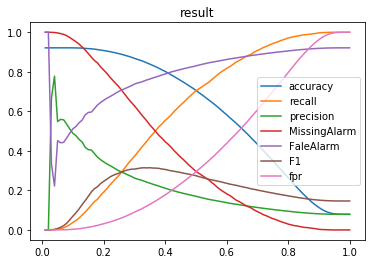

In [9]:
x_list = 1 - np.arange(0, 1, 0.01)
plt.title('result')
plt.plot(x_list, accuracy_list, label='accuracy')
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.plot(x_list, MissingAlarm_list, label='MissingAlarm')
plt.plot(x_list, FalseAlarm_list, label='FaleAlarm')
plt.plot(x_list, F1_list, label='F1')
plt.plot(x_list, fpr_list, label='fpr')
plt.legend()
plt.show()

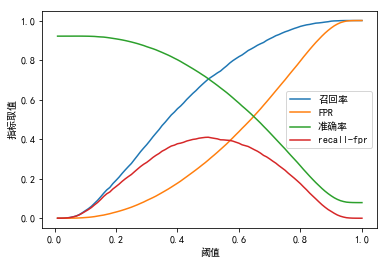

In [10]:
plt.rcParams['font.sans-serif'] = [u'SimHei']

plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams['font.size'] = 16
plt.plot(x_list, recall_list, label='召回率')
plt.plot(x_list, fpr_list, label='FPR')
plt.plot(x_list, accuracy_list, label='准确率')
plt.plot(x_list, [recall_list[i] - fpr_list[i] for i in range(len(recall_list))], label='recall-fpr')
plt.legend()
plt.xlabel('阈值')
plt.ylabel('指标取值')
plt.show()

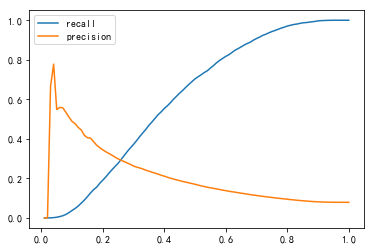

In [11]:
plt.plot(x_list, recall_list, label='recall')
plt.plot(x_list, precision_list, label='precision')
plt.legend()
plt.show()

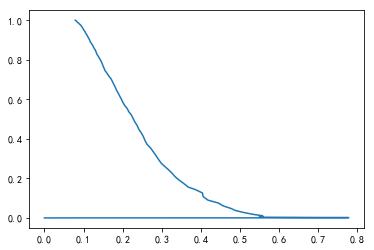

In [12]:
plt.plot(precision_list, recall_list, label='precision')
plt.show()

In [13]:
K_S = max([recall_list[i] - fpr_list[i] for i in range(len(recall_list))])
print(K_S)
np.argmax([recall_list[i] - fpr_list[i] for i in range(len(recall_list))])

0.4096665283040108


50

In [14]:
accuracy_list[50]

0.7058680064387103

In [15]:
X.columns

Index(['pre_app_merged_NAME_PAYMENT_TYPE_Cash through the bank',
       'bureau_merged_DAYS_ENDDATE_FACT_max',
       'pre_app_merged_NAME_CONTRACT_STATUS_Approved',
       'bureau_merged_DAYS_ENDDATE_FACT_mean',
       'pre_app_merged_CODE_REJECT_REASON_SCOFR', 'AMT_ANNUITY',
       'pre_app_merged_DAYS_LAST_DUE_1ST_VERSION_std',
       'pre_app_merged_installments_DAYS_INSTALMENT_min_std', 'TOTALAREA_MODE',
       'EXT_SOURCE_3', 'pre_app_merged_DAYS_LAST_DUE_mean', 'DAYS_ID_PUBLISH',
       'pre_app_merged_PRODUCT_COMBINATION_Cash X-Sell: low',
       'pre_app_merged_PRODUCT_COMBINATION_POS industry with interest',
       'EXT_SOURCE_2', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'pre_app_merged_NAME_CLIENT_TYPE_New',
       'pre_app_merged_NAME_CONTRACT_TYPE_Consumer loans',
       'pre_app_merged_CNT_PAYMENT_min',
       'pre_app_merged_PRODUCT_COMBINATION_Card Street',
       'pre_app_merged_DAYS_FIRST_DRAWING_min',
       'pre_app_merged_NAME_CONTRACT_TYPE_Revolving loan

In [16]:
X.dtypes.value_counts()

float64    53
int64      12
dtype: int64